### TS4

Gomez Lucero - Waichman Scigliano.

En esta entrega se trabajó en conjunto la TS4.

### 1. Introducción

En esta experiencia se estudió el desempeño de distintos **estimadores de amplitud y frecuencia** aplicados a una señal senoidal con ruido blanco gaussiano aditivo (AWGN).  
El objetivo fue analizar cómo afectan el nivel de ruido y la elección de la ventana espectral sobre la **precisión estadística** de dichos estimadores, observando su **sesgo** y **varianza**.

Se trabajó con una señal senoidal de amplitud $A_0 = 2$ y potencia $P_s = A_0^2 / 2 = 2\,\text{W}$, muestreada a una frecuencia de $f_s = 1000\,\text{Hz}$ con un total de $N = 1000$ muestras por realización.  
Se generó un conjunto de $R = 200$ realizaciones independientes, cada una con una ligera variación aleatoria en su frecuencia, modelada con $f_r$, un parametro uniformemente distribuido en el rango $[-2, 2]$ bins de frecuencia.  
De esta manera se simuló una senoidal estocástica con *jitter en frecuencia* y ruido gaussiano aditivo.

El ruido se ajustó para obtener relaciones señal–ruido de $SNR = 3\,\text{dB}$ y $SNR = 10\,\text{dB}$, generando así dos escenarios.  
La desviación estándar del ruido se calculó en función de la potencia de la señal, según $\sigma_n = \sqrt{P_s \cdot 10^{-SNR_{dB}/10}}$-

Cada señal se representó en forma **matricial** ($N \times R$), donde cada columna corresponde a una realización independiente.  
A cada una se le aplicaron diferentes **ventanas espectrales**: Rectangular (por defecto), Flattop, Blackman–Harris y Hamming.  
Posteriormente se calculó la **Transformada Rápida de Fourier (FFT)** con *zero padding* de $10N$ puntos para mejorar la resolución espectral y se implementaron los **estimadores de amplitud y frecuencia**, sobre los cuales se evaluaron sus **sesgos y varianzas**.



In [7]:
import numpy as np
from numpy.fft import fft
import scipy.signal.windows as window
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
np.random.seed(7)

#%% DATOS
N = 1000
fs = N
deltaF = fs/N
Npadding = 10* N
deltaF_Padding = fs/Npadding

Ts = 1/fs
k = np.arange(N)*deltaF
t = np.arange(N)*Ts

#a0 = np.sqrt(2)
a0 = 2
R = 200
fr = np.random.uniform(-2, 2, R)
f1 = (N / 4 + fr) * deltaF
PP = a0
t = t.reshape(-1,1)

pot_senal = (a0**2)/2

matriz_t = np.tile(t, (1,R))
matriz_ff = np.tile(f1, (N,1))

freq = np.fft.fftfreq(Npadding, d = 1/fs)

#%% ARMADO DE MATRIZ DE SENOIDALES Y VENTANAS. 
matriz_x = a0 * np.sin(2 * np.pi * matriz_ff * matriz_t)

flattop = window.flattop(N).reshape((-1,1))
bmh = window.blackmanharris(N).reshape((-1,1))
hamming = window.hamming(N).reshape((-1,1))

# matriz_x: N x R  (solo senoidal, SIN ruido)
P_signal_cols = (1/N) * np.sum(matriz_x**2, axis=0)   # potencia de cada realización
P_signal_mean = P_signal_cols.mean()

## CHEQUEO DE POTENCIA 
print("Potencias señal (min / mean / max):",
      P_signal_cols.min(), P_signal_mean, P_signal_cols.max())

# ¿Está normalizada a 1?
print("¿Potencia ~ 2 en TODAS las columnas?",
      np.allclose(P_signal_cols, 2.0, rtol=1e-3, atol=1e-3))

## FUNCIONES PARA ARMAR LAS TABLAS DE VALORES.
def _fmt(x):
    # Asegura float y formato científico prolijo
    return f"{np.asarray(x, dtype=float): .6e}"

def _print_block(title, rows):
    print(f"\n[{title}]")
    print(f"{'Ventana':<18}{'Sesgo':>16}{'Varianza':>16}{'Desvío':>16}")
    print("-"*66)
    for (vent, bias, var) in rows:
        std = np.sqrt(np.maximum(var, 0.0))  # por estabilidad numérica
        print(f"{vent:<18}{_fmt(bias):>16}{_fmt(var):>16}{_fmt(std):>16}")




Potencias señal (min / mean / max): 1.998000006961332 1.9989323414757398 1.999999982576173
¿Potencia ~ 2 en TODAS las columnas? True


### 2. Análisis y resultados

Para ambas condiciones de ruido se verificó primero la correcta normalización de la señal y el escalado del ruido.  
La potencia promedio medida fue $P_s \approx 2\,\text{W}$, en concordancia con el valor teórico $A_0^2/2$.  

#### 2.1 Estimadores de amplitud

Se analizaron dos métodos para estimar la amplitud:

1. **Por pico**: se toma el máximo módulo del espectro $|X[k]|$ y se tuvo que normalizar por un factor llamado "current gain" que es distinto para cada ventana utilizada.   
2. **Por bin fijo ($N/4$)**: se evalúa la amplitud en el bin teórico de la frecuencia fundamental, con el fin de observar el efecto de *scalloping* cuando la frecuencia no coincide exactamente con un bin FFT.

En ambos casos se calcularon el **sesgo**, la **varianza** y el **desvío estándar** para cada ventana.  

Los resultados mostraron que:

- Para $SNR = 3\,\text{dB}$, las ventanas **Rectangular** y **Hamming** presentan la menor varianza, mientras que **Flattop** exhibe mayor dispersión pero menor sesgo.  
- En el caso del bin fijo, todas las ventanas sufren *scalloping*, con un sesgo negativo significativo. Sin embargo, **Flattop** logra compensar parcialmente ese error, mostrando la menor desviación media (≈ −0.17 para 3 dB y 10 dB).  
- Al aumentar el SNR a 10 dB, la varianza de todos los estimadores disminuye.

#### 2.2 Estimadores de frecuencia

El estimador de frecuencia se basó en la posición del máximo del espectro en la mitad positiva de la FFT:

$
\hat{f} = \arg\max_{k>0} |X[k]|
$

A partir de él se calcularon los errores por realización respecto de la frecuencia real con jitter:

$
e_f = \hat{f} - f_{\text{true}}
$

y luego su sesgo y varianza.  

Los resultados indican que:

- Las ventanas **Rectangular**, **Hamming** y **Blackman–Harris** presentan varianzas bajas (del orden de $10^{-3}$) y sesgos despreciables (< 0.01 Hz).  
- **Flattop**, en cambio, muestra varianzas mucho mayores debido a su lóbulo principal más ancho, lo que disminuye la resolución frecuencial.  
- Con mayor SNR la dispersión de los errores disminuye en todos los casos, como se esperaba teóricamente.

#### 2.3 Interpretación general

El uso de ventanas afecta de manera diferente la estimación según el parámetro observado:

- **Rectangular**: mejor precisión en frecuencia, peor control de *leakage*.  
- **Flattop**: mejor exactitud de amplitud (menor sesgo), pero alta varianza y peor frecuencia.  
- **Hamming / Blackman–Harris**: compromiso intermedio, buena estabilidad general.

Los histogramas y espectros graficados en cada caso confirman visualmente estas tendencias:  
a menor SNR, mayor dispersión en las estimaciones, y a mayor SNR, las distribuciones se concentran alrededor del valor real.


In [8]:
#%% ESTE FOR LO HICIMOS PARA ARMAR LA TABLA PARA SNR = 3 Y SNR = 10
for SNRdb in [3, 10]:
    print(f"\n===== RESULTADOS PARA SNR = {SNRdb} dB =====")
    sigma_ruido = np.sqrt(pot_senal * 10**(-SNRdb/10))
    matriz_ruido = np.random.normal(0, sigma_ruido , size=(N, R))
    matriz_xn = matriz_x + matriz_ruido

    xx_vent_flt = matriz_xn * flattop
    xx_vent_bmh = matriz_xn * bmh
    xx_vent_hmg = matriz_xn * hamming

    # FFT 
    matriz_Xn1 = (1/N) * fft(matriz_xn, n = Npadding, axis = 0)
    matriz_Xn2 = (1/N) * fft(xx_vent_flt, n = Npadding, axis = 0)
    matriz_Xn3 = (1/N) * fft(xx_vent_bmh, n = Npadding, axis = 0)
    matriz_Xn4 = (1/N) * fft(xx_vent_hmg, n = Npadding, axis = 0)

    P_sig = np.mean(matriz_x**2)
    P_n   = np.mean(matriz_ruido**2)
    SNR_meas_db = 10*np.log10(P_sig / P_n)
    Ps_cols = (1/N)*np.sum(matriz_x**2, axis=0)
    Pn_cols = (1/N)*np.sum(matriz_ruido**2, axis=0)
    SNR_cols_db = 10*np.log10(Ps_cols / Pn_cols)
    print(f"SNR medido (global): {SNR_meas_db:.2f} dB")
    print(f"SNR medido (mean±std por realización): {SNR_cols_db.mean():.2f} ± {SNR_cols_db.std():.2f} dB")
#%%    ESTIMADORES DE AMPLITUD DE DOS FORMAS
    cg_rect = 1.0
    cg_flt  = flattop.mean()
    cg_bmh  = bmh.mean()
    cg_hmg  = hamming.mean()

    # # Estimador de amplitud (valor del pico en cada columna)
    amp_est1 = 2*np.max(np.abs(matriz_Xn1), axis=0) / cg_rect
    amp_est2 = 2*np.max(np.abs(matriz_Xn2), axis=0) /cg_flt        
    amp_est3 = 2*np.max(np.abs(matriz_Xn3), axis=0) /cg_bmh      
    amp_est4 = 2*np.max(np.abs(matriz_Xn4), axis=0) /cg_hmg    

    sesgo_rect = np.mean(amp_est1) - a0
    sesgo_flat = np.mean(amp_est2) - a0
    sesgo_bmh  = np.mean(amp_est3) - a0
    sesgo_hmg  = np.mean(amp_est4) - a0

    var_rect = np.var(amp_est1, ddof=0)
    var_flat = np.var(amp_est2, ddof=0)
    var_bhm  = np.var(amp_est3, ddof=0)
    var_hmg  = np.var(amp_est4, ddof=0)

    #estimador pero solamente en la feta de N//4
    amp_est1_bin = 2*np.abs(matriz_Xn1[Npadding//4, :]) / cg_rect
    amp_est2_bin = 2*np.abs(matriz_Xn2[Npadding//4, :]) / cg_flt
    amp_est3_bin = 2*np.abs(matriz_Xn3[Npadding//4, :]) / cg_bmh
    amp_est4_bin = 2*np.abs(matriz_Xn4[Npadding//4, :]) / cg_hmg    

    sesgo_rect_bin = np.mean(amp_est1_bin) - a0
    sesgo_flat_bin = np.mean(amp_est2_bin) - a0
    sesgo_bmh_bin  = np.mean(amp_est3_bin) - a0
    sesgo_hmg_bin  = np.mean(amp_est4_bin) - a0

    var_rect_bin = np.var(amp_est1_bin, ddof=0)
    var_flat_bin = np.var(amp_est2_bin, ddof=0)
    var_bhm_bin  = np.var(amp_est3_bin, ddof=0)
    var_hmg_bin  = np.var(amp_est4_bin, ddof=0)

#%% ESTIMADORES DE FRECUENCIA DE 1 MANERA 
    # Parte positiva de cada ventana
    X1p = matriz_Xn1[:Npadding//2+1, :]
    X2p = matriz_Xn2[:Npadding//2+1, :]
    X3p = matriz_Xn3[:Npadding//2+1, :]
    X4p = matriz_Xn4[:Npadding//2+1, :]

    idx1 = np.argmax(np.abs(X1p), axis=0)
    idx2 = np.argmax(np.abs(X2p), axis=0)
    idx3 = np.argmax(np.abs(X3p), axis=0)
    idx4 = np.argmax(np.abs(X4p), axis=0)

    frec_est1 = idx1 * deltaF_Padding #- f1
    frec_est2 = idx2 * deltaF_Padding #- f1
    frec_est3 = idx3 * deltaF_Padding #- f1
    frec_est4 = idx4 * deltaF_Padding #- f1

    # Frecuencia verdadera por realización (vector R,)
    #f1  # (= (N/4 + fr) * deltaF)

    # Errores por realización
    err1 = frec_est1 - f1
    err2 = frec_est2 - f1
    err3 = frec_est3 - f1
    err4 = frec_est4 - f1

    sesgo= np.mean(frec_est1) - np.mean(f1)

    # Sesgo y varianza muestral, SON ESCALARES. 
    sesgo_rect1 = float(err1.mean());  var_rect1 = float(err1.var(ddof=0))
    sesgo_flat2 = float(err2.mean());  var_flat2 = float(err2.var(ddof=0))
    sesgo_bmh3  = float(err3.mean());  var_bhm3  = float(err3.var(ddof=0))
    sesgo_hmg4  = float(err4.mean());  var_hmg4  = float(err4.var(ddof=0))
    
#%%TABLA DE VALORES

    print(f"\n=== TABLA SESGO Y VARIANZA — SNR = {SNRdb} dB ===")
    
    # --- Amplitud — Pico (máximo FFT ×2/CG) ---
    rows_amp_peak = [
        ("Rectangular",     sesgo_rect,     var_rect),
        ("Flattop",         sesgo_flat,     var_flat),
        ("Blackman-Harris", sesgo_bmh,      var_bhm),
        ("Hamming",         sesgo_hmg,      var_hmg),
    ]
    _print_block("AMPLITUD — Pico (×2/CG)", rows_amp_peak)
    
    # --- Amplitud — Bin fijo fs/4 (scalloping) ---
    rows_amp_bin = [
        ("Rectangular",     sesgo_rect_bin,     var_rect_bin),
        ("Flattop",         sesgo_flat_bin,     var_flat_bin),
        ("Blackman-Harris", sesgo_bmh_bin,      var_bhm_bin),
        ("Hamming",         sesgo_hmg_bin,      var_hmg_bin),
    ]
    _print_block("AMPLITUD — Bin fijo fs/4", rows_amp_bin)
    
    # --- Frecuencia — Argmax (f̂ − f_true) ---
    rows_freq = [
        ("Rectangular",     sesgo_rect1,    var_rect1),
        ("Flattop",         sesgo_flat2,    var_flat2),
        ("Blackman-Harris", sesgo_bmh3,     var_bhm3),
        ("Hamming",         sesgo_hmg4,     var_hmg4),
    ]
    _print_block("FRECUENCIA — Argmax (f̂ − f_true)", rows_freq)





===== RESULTADOS PARA SNR = 3 dB =====
SNR medido (global): 3.01 dB
SNR medido (mean±std por realización): 3.01 ± 0.18 dB

=== TABLA SESGO Y VARIANZA — SNR = 3 dB ===

[AMPLITUD — Pico (×2/CG)]
Ventana                      Sesgo        Varianza          Desvío
------------------------------------------------------------------
Rectangular           2.352476e-04    2.356997e-03    4.854891e-02
Flattop               1.777426e-02    6.873421e-03    8.290610e-02
Blackman-Harris       1.963747e-03    3.916823e-03    6.258452e-02
Hamming               1.000016e-03    2.834239e-03    5.323757e-02

[AMPLITUD — Bin fijo fs/4]
Ventana                      Sesgo        Varianza          Desvío
------------------------------------------------------------------
Rectangular          -1.228430e+00    4.510890e-01    6.716316e-01
Flattop              -1.598448e-01    5.006292e-02    2.237474e-01
Blackman-Harris      -6.694062e-01    2.799007e-01    5.290564e-01
Hamming              -1.034085e+00    5.

Estos graficos bla bla bla



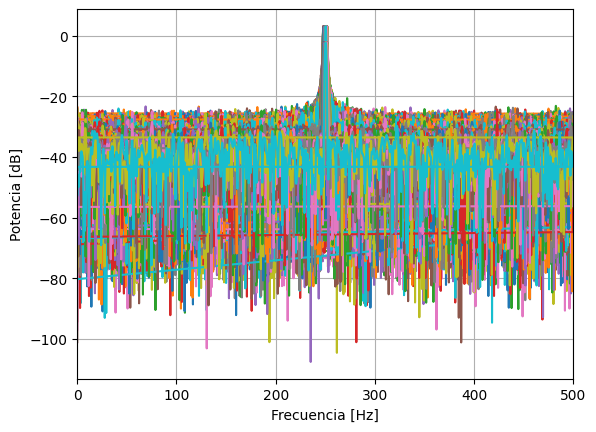

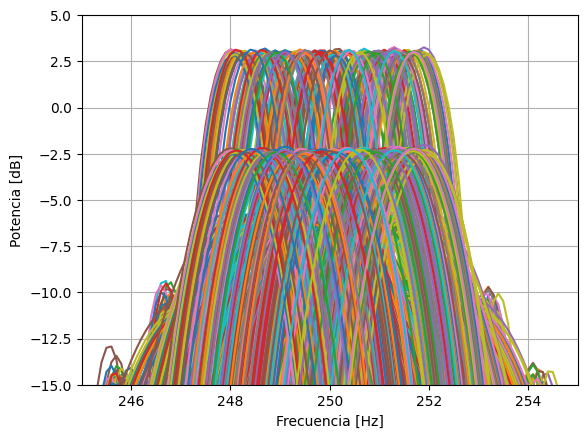

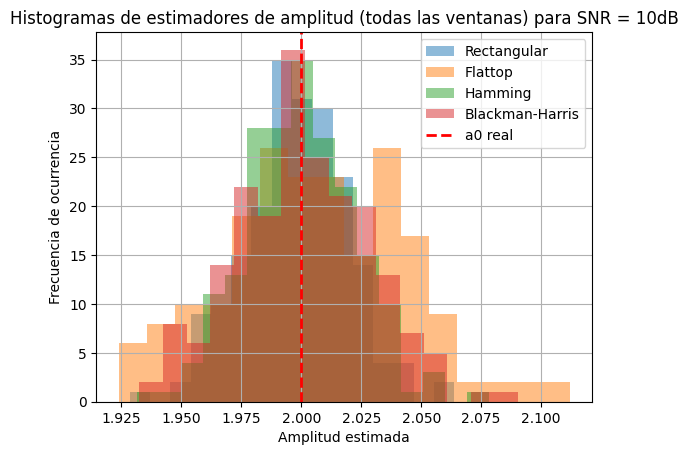

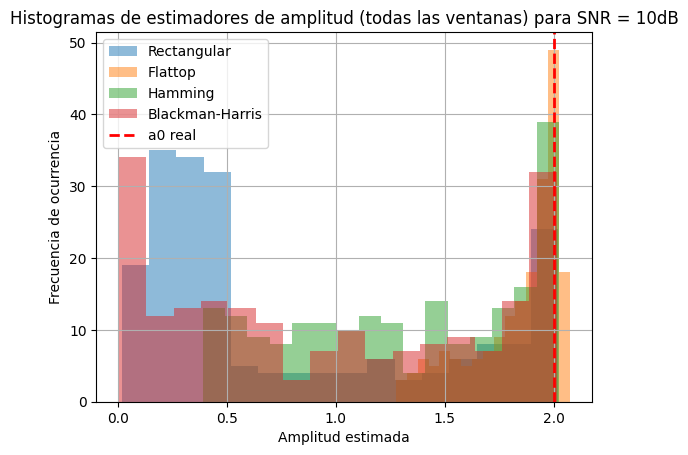

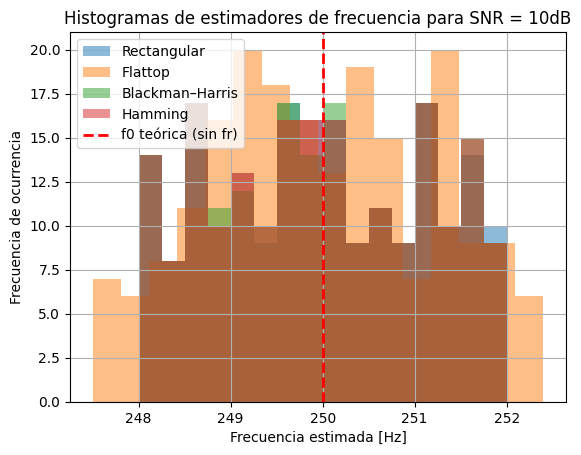

In [9]:
#%% GRAFICOS

plt.figure()
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn1)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn2)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn3)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn4)**2) + 3)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.xlim(0,fs/2)
plt.grid(True)

plt.figure()
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn1)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn2)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn3)**2) + 3)
plt.plot(freq, 10*np.log10(np.abs(matriz_Xn4)**2) + 3)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.xlim(245,255)
plt.ylim(-15,5)
plt.grid(True)

plt.figure()
plt.hist(amp_est1, bins=16, alpha=0.5, label="Rectangular")
plt.hist(amp_est2, bins=16, alpha=0.5, label="Flattop")
plt.hist(amp_est4, bins=16, alpha=0.5, label="Hamming")
plt.hist(amp_est3, bins=16, alpha=0.5, label="Blackman-Harris")
plt.axvline(a0, color='red', linestyle='--', linewidth=2, label="a0 real")
plt.title("Histogramas de estimadores de amplitud (todas las ventanas) para SNR = 10dB")
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia de ocurrencia")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.hist(amp_est1_bin, bins=16, alpha=0.5, label="Rectangular")
plt.hist(amp_est2_bin, bins=16, alpha=0.5, label="Flattop")
plt.hist(amp_est3_bin, bins=16, alpha=0.5, label="Hamming")
plt.hist(amp_est4_bin, bins=16, alpha=0.5, label="Blackman-Harris")
plt.axvline(a0, color='red', linestyle='--', linewidth=2, label="a0 real")
plt.title("Histogramas de estimadores de amplitud (todas las ventanas) para SNR = 10dB")
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia de ocurrencia")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.hist(frec_est1, bins=16, alpha=0.5, label="Rectangular")
plt.hist(frec_est2, bins=16, alpha=0.5, label="Flattop")
plt.hist(frec_est3, bins=16, alpha=0.5, label="Blackman–Harris")
plt.hist(frec_est4, bins=16, alpha=0.5, label="Hamming")
plt.axvline(fs/4, color='red', ls='--', lw=2, label='f0 teórica (sin fr)')
plt.title("Histogramas de estimadores de frecuencia para SNR = 10dB")
plt.xlabel("Frecuencia estimada [Hz]")
plt.ylabel("Frecuencia de ocurrencia")
plt.legend(); plt.grid(True); plt.show()


### 3. Conclusión

El estudio permitió observar cómo el nivel de ruido y la elección de la ventana espectral influyen directamente en el **sesgo** y la **varianza** de los estimadores de amplitud y frecuencia.

Con un nivel de ruido alto ($SNR = 3\,\text{dB}$), las estimaciones presentan mayor dispersión, mientras que al aumentar el $SNR$ a $10\,\text{dB}$ las varianzas disminuyen significativamente, manteniendo constante el sesgo medio.  
Esto confirma el comportamiento teórico esperado: un mayor $SNR$ mejora la precisión estadística de los estimadores.

En cuanto a las ventanas:

- **Rectangular** ofreció la mejor resolución en frecuencia, pero con mayor *leakage* y un sesgo de amplitud notable cuando la frecuencia no cae exactamente en un bin FFT.  
- **Flattop** redujo el sesgo de amplitud en condiciones de *scalloping*, aunque a costa de una mayor varianza y menor resolución frecuencial.  
- **Hamming** y **Blackman–Harris** mostraron un equilibrio adecuado, con buena estabilidad en ambas estimaciones.

En síntesis, la ventana Flattop resulta óptima cuando el objetivo es **medir amplitudes precisas**, mientras que las ventanas Hamming o Blackman–Harris son preferibles para **estimación de frecuencia**.  
El método matricial permitió obtener resultados estadísticamente robustos y verificar experimentalmente los compromisos entre **resolución**, **varianza** y **sesgo** en la estimación espectral.
